# From SVD to EOFs and PCA: Patterns in Earth Science Data

In the previous notebook we developed the theory of the Singular Value Decomposition. Now we will apply it to real climate data and show how it connects to two methods used throughout the Earth sciences:

- **Empirical Orthogonal Functions (EOFs)** — the standard tool in climate science for identifying dominant spatial patterns and their temporal variability
- **Principal Component Analysis (PCA)** — the standard tool in statistics and machine learning for dimensionality reduction

These are not three different methods — they are **three views of the same underlying mathematics**. This notebook makes that connection explicit.

## Learning Goals

By the end of this notebook you should be able to:
1. Apply the SVD to a real spatiotemporal dataset and interpret the results
2. Explain what EOFs and Principal Components (PCs) are and how they arise from the SVD
3. Understand the role of the **anomaly (mean-removal)** step and why it matters
4. Identify well-known climate modes (e.g., ENSO) in the leading EOFs of sea surface temperature
5. Reproduce an EOF/PCA analysis using only `np.linalg.svd` and verify it against `sklearn`

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

np.set_printoptions(precision=4, suppress=True)

---
## Part 1: Loading Global Sea Surface Temperature

We will use the **NOAA Extended Reconstructed SST v5 (ERSST v5)** dataset — a widely used, quality-controlled monthly sea surface temperature product on a 2° global grid. The xarray library includes a cached subset of this dataset (1970–2021) that we can load reliably without worrying about network transfer limits.

In [22]:
ds = xr.tutorial.open_dataset("ersstv5")
ds

<xarray.Dataset> Size: 40MB
Dimensions:    (time: 624, nbnds: 2, lat: 89, lon: 180)
Coordinates:
  * time       (time) datetime64[ns] 5kB 1970-01-01 1970-02-01 ... 2021-12-01
  * lat        (lat) float32 356B 88.0 86.0 84.0 82.0 ... -84.0 -86.0 -88.0
  * lon        (lon) float32 720B 0.0 2.0 4.0 6.0 ... 352.0 354.0 356.0 358.0
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) float64 10kB ...
    sst        (time, lat, lon) float32 40MB ...
Attributes: (12/37)
    climatology:               Climatology is based on 1971-2000 SST, Xue, Y....
    description:               In situ data: ICOADS2.5 before 2007 and NCEP i...
    keywords_vocabulary:       NASA Global Change Master Directory (GCMD) Sci...
    keywords:                  Earth Science > Oceans > Ocean Temperature > S...
    instrument:                Conventional thermometers
    source_comment:            SSTs were observed by conventional thermometer...
    ...                        ...
    creator_url_original:      https://www.ncei.noaa.gov
    license:                   No constraints on data access or use
    comment:                   SSTs were observed by conventional thermometer...
    summary:                   ERSST.v5 is developed based on v4 after revisi...
    dataset_title:             NOAA Extended Reconstructed SST V5
    data_modified:             2022-06-07

In [23]:
sst = ds["sst"]
print(f"SST shape: {sst.shape}")
print(f"  time:  {sst.sizes['time']} months ({sst.sizes['time']//12} years)")
print(f"  lat:   {sst.sizes['lat']} points")
print(f"  lon:   {sst.sizes['lon']} points")

SST shape: (624, 89, 180)
  time:  624 months (52 years)
  lat:   89 points
  lon:   180 points


Text(0.5, 1.0, 'Sea Surface Temperature — January 2015')

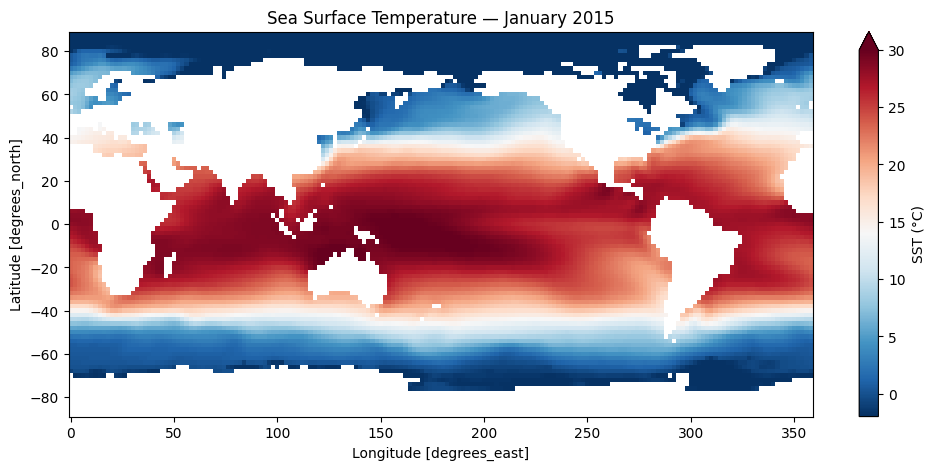

In [24]:
# Quick look: a single month
fig, ax = plt.subplots(figsize=(12, 5))
sst.sel(time="2015-01", method="nearest").plot(
    ax=ax, cmap="RdBu_r", vmin=-2, vmax=30,
    cbar_kwargs={"label": "SST (°C)"}
)
ax.set_title("Sea Surface Temperature — January 2015")

---
## Part 2: Preparing the Data Matrix — The Anomaly Step

Before applying the SVD, there is a critical preprocessing step: **removing the time mean at each grid point**. The resulting field is called the **anomaly**.

### Why remove the mean?

If we apply the SVD directly to the raw SST field, the first mode will simply capture the **mean spatial pattern** (the tropics are warm, the poles are cold). That's not very informative — we already know that!

What we actually want to find are the dominant **patterns of variability**: how does the SST field fluctuate around its average state? By subtracting the time mean, we center the data so that the SVD (and hence PCA/EOF) focuses on variance rather than the mean.

This is the key connection:
> **PCA is the SVD applied to mean-centered data.**

$$
\mathbf{X}' = \mathbf{X} - \bar{\mathbf{X}}
$$

where $\bar{\mathbf{X}}$ is the temporal mean at each spatial location.

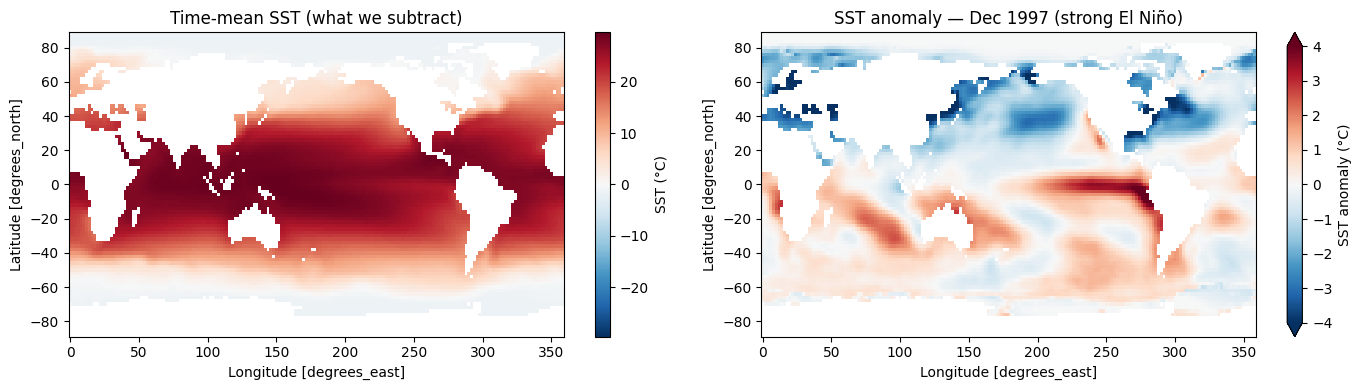

In [25]:
# Compute and remove the time mean (the "climatology")
sst_mean = sst.mean(dim="time")
sst_anom = sst - sst_mean

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

sst_mean.plot(ax=axes[0], cmap="RdBu_r", cbar_kwargs={"label": "SST (°C)"})
axes[0].set_title("Time-mean SST (what we subtract)")

sst_anom.sel(time="1997-12", method="nearest").plot(
    ax=axes[1], cmap="RdBu_r", vmin=-4, vmax=4,
    cbar_kwargs={"label": "SST anomaly (°C)"}
)
axes[1].set_title("SST anomaly — Dec 1997 (strong El Niño)")
plt.tight_layout()

### Building the 2D data matrix

The SST anomaly field is 3-dimensional: `(time, lat, lon)`. To apply the SVD, we need a 2D matrix. Following the Brunton & Kutz convention from the theory notebook, we want:

$$
\mathbf{X}' \in \mathbb{R}^{n \times m}
$$

where $n$ = number of spatial points (lat $\times$ lon) and $m$ = number of time steps.

We "flatten" or "stack" the spatial dimensions into a single dimension. We also need to handle the land mask — ocean-only grid points with valid data.

In [26]:
# Load into memory and handle NaNs (land/ice points)
sst_anom_values = sst_anom.values  # shape: (time, lat, lon)
n_time, n_lat, n_lon = sst_anom_values.shape
print(f"Original shape: ({n_time}, {n_lat}, {n_lon})")

# Reshape: flatten (lat, lon) -> single spatial dimension
# Result shape: (time, n_space)
sst_2d = sst_anom_values.reshape(n_time, n_lat * n_lon)

# Create an ocean mask: keep only points that are valid at ALL time steps.
# This is stricter than checking "NaN at all times" — we require complete
# temporal coverage so the SVD gets a clean matrix with no missing data.
ocean_mask = ~np.any(np.isnan(sst_2d), axis=0)
n_ocean = ocean_mask.sum()
print(f"Total grid points: {n_lat * n_lon}")
print(f"Ocean grid points (valid at all times): {n_ocean}")

# Keep only ocean points — no NaN remain after this step
sst_ocean = sst_2d[:, ocean_mask]

# Transpose to get the Brunton & Kutz convention: X is (n_space x n_time)
X = sst_ocean.T
print(f"\nData matrix X shape: {X.shape}  (n_space x n_time)")
print(f"X value range: [{X.min():.3f}, {X.max():.3f}]")

Original shape: (624, 89, 180)
Total grid points: 16020
Ocean grid points (valid at all times): 10988

Data matrix X shape: (10988, 624)  (n_space x n_time)
X value range: [-13.657, 17.550]


---
## Part 3: SVD of the SST Anomaly Field

Now we apply the SVD to the anomaly matrix:

$$
\mathbf{X}' = \mathbf{U} \boldsymbol{\Sigma} \mathbf{V}^T
$$

From the theory notebook, recall:
- Columns of $\mathbf{U}$: spatial patterns (what we'll call **EOFs**)
- Diagonal of $\boldsymbol{\Sigma}$: importance of each pattern
- Rows of $\mathbf{V}^T$ (columns of $\mathbf{V}$): temporal evolution (what we'll call **Principal Components**)

In [27]:
# Economy SVD — we only need min(n, m) modes
U, s, Vt = np.linalg.svd(X, full_matrices=False)

print(f"U shape:  {U.shape}   (spatial modes)")
print(f"s shape:  {s.shape}")
print(f"Vt shape: {Vt.shape}  (temporal modes)")
print(f"\nFirst 10 singular values: {s[:10]}")

U shape:  (10988, 624)   (spatial modes)
s shape:  (624,)
Vt shape: (624, 624)  (temporal modes)

First 10 singular values: [4560.4453  887.1277  815.5045  543.5903  475.5008  365.9462  280.5526
  273.0521  236.9167  231.6675]


### Singular value spectrum and explained variance

Mode 1: 85.5% variance  (cumulative: 85.5%)
Mode 2: 3.2% variance  (cumulative: 88.8%)
Mode 3: 2.7% variance  (cumulative: 91.5%)
Mode 4: 1.2% variance  (cumulative: 92.7%)
Mode 5: 0.9% variance  (cumulative: 93.6%)


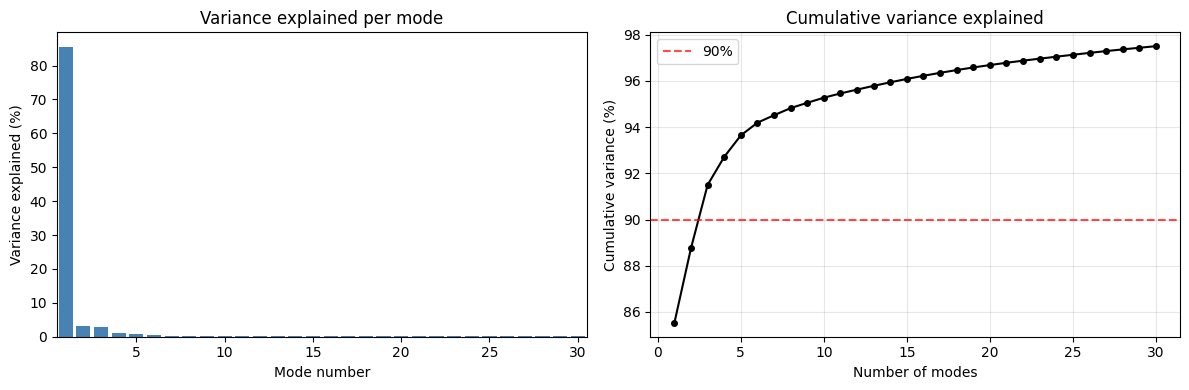

In [28]:
# Variance explained by each mode
variance = s**2
variance_fraction = variance / variance.sum()
cumulative_variance = np.cumsum(variance_fraction)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

n_show = 30
axes[0].bar(np.arange(1, n_show + 1), variance_fraction[:n_show] * 100, color='steelblue')
axes[0].set_xlabel('Mode number')
axes[0].set_ylabel('Variance explained (%)')
axes[0].set_title('Variance explained per mode')
axes[0].set_xlim(0.5, n_show + 0.5)

axes[1].plot(np.arange(1, n_show + 1), cumulative_variance[:n_show] * 100, 'ko-', markersize=4)
axes[1].axhline(90, color='r', linestyle='--', alpha=0.7, label='90%')
axes[1].set_xlabel('Number of modes')
axes[1].set_ylabel('Cumulative variance (%)')
axes[1].set_title('Cumulative variance explained')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()

for i in range(5):
    print(f"Mode {i+1}: {variance_fraction[i]*100:.1f}% variance  (cumulative: {cumulative_variance[i]*100:.1f}%)")

---
## Part 4: The SVD ↔ EOF ↔ PCA Rosetta Stone

Let's now make the connections between the three frameworks precise. The table below translates between the SVD vocabulary (from the theory notebook) and the language used in climate science (EOFs) and statistics/ML (PCA).

| SVD | EOF analysis | PCA | What it represents |
|-----|-------------|-----|--------------------|
| Left singular vectors $\mathbf{u}_k$ | **EOF $k$** | Loading vectors / principal axes | Spatial pattern of the $k$-th mode |
| Singular values $\sigma_k$ | (related to eigenvalues) | (related to eigenvalues) | Importance / amplitude of mode $k$ |
| $\sigma_k \cdot \mathbf{v}_k$ (rows of $\boldsymbol{\Sigma}\mathbf{V}^T$) | **Principal Component $k$** (PC $k$) | **PC scores** | Time series of mode $k$'s amplitude |
| $\sigma_k^2 / (m - 1)$ | Eigenvalue $\lambda_k$ of covariance matrix | Eigenvalue $\lambda_k$ of covariance matrix | Variance explained by mode $k$ |

### The key relationships

Starting from the mean-centered data matrix $\mathbf{X}' \in \mathbb{R}^{n \times m}$ with SVD $\mathbf{X}' = \mathbf{U}\boldsymbol{\Sigma}\mathbf{V}^T$:

**EOFs** are the columns of $\mathbf{U}$:
$$\text{EOF}_k = \mathbf{u}_k$$

**Principal Components** are the singular values times the right singular vectors:
$$\text{PC}_k = \sigma_k \, \mathbf{v}_k$$

Equivalently, the matrix of all PCs is:
$$\mathbf{P} = \boldsymbol{\Sigma} \mathbf{V}^T = \mathbf{U}^T \mathbf{X}'$$

This last form reveals the projection interpretation: the PCs are obtained by **projecting the data onto the EOF directions**.

**The covariance matrix** of the data is:
$$\mathbf{C} = \frac{1}{m-1} \mathbf{X}' {\mathbf{X}'}^T = \frac{1}{m-1} \mathbf{U} \boldsymbol{\Sigma}^2 \mathbf{U}^T$$

So the EOFs ($\mathbf{U}$) are the eigenvectors of the covariance matrix, and the eigenvalues are $\lambda_k = \sigma_k^2 / (m-1)$. This is exactly PCA.

---
## Part 5: Visualizing the Leading EOFs and PCs

Let's extract the EOFs and PCs from our SVD and visualize them.

In [29]:
# Extract EOFs and PCs from the SVD
n_modes = 4

# EOFs = columns of U, reshaped back to (lat, lon) maps
eofs = np.full((n_modes, n_lat, n_lon), np.nan)
for k in range(n_modes):
    eof_1d = U[:, k]  # shape: (n_ocean,)
    eof_full = np.full(n_lat * n_lon, np.nan)
    eof_full[ocean_mask] = eof_1d
    eofs[k] = eof_full.reshape(n_lat, n_lon)

# PCs = sigma_k * v_k (rows of Sigma @ V^T)
pcs = np.diag(s[:n_modes]) @ Vt[:n_modes, :]

# Create xarray objects for nice plotting
time_coord = sst.coords["time"].values

eof_da = xr.DataArray(
    eofs, 
    dims=["mode", "lat", "lon"],
    coords={"mode": np.arange(1, n_modes + 1), "lat": sst.lat, "lon": sst.lon}
)

pc_da = xr.DataArray(
    pcs, 
    dims=["mode", "time"],
    coords={"mode": np.arange(1, n_modes + 1), "time": time_coord}
)

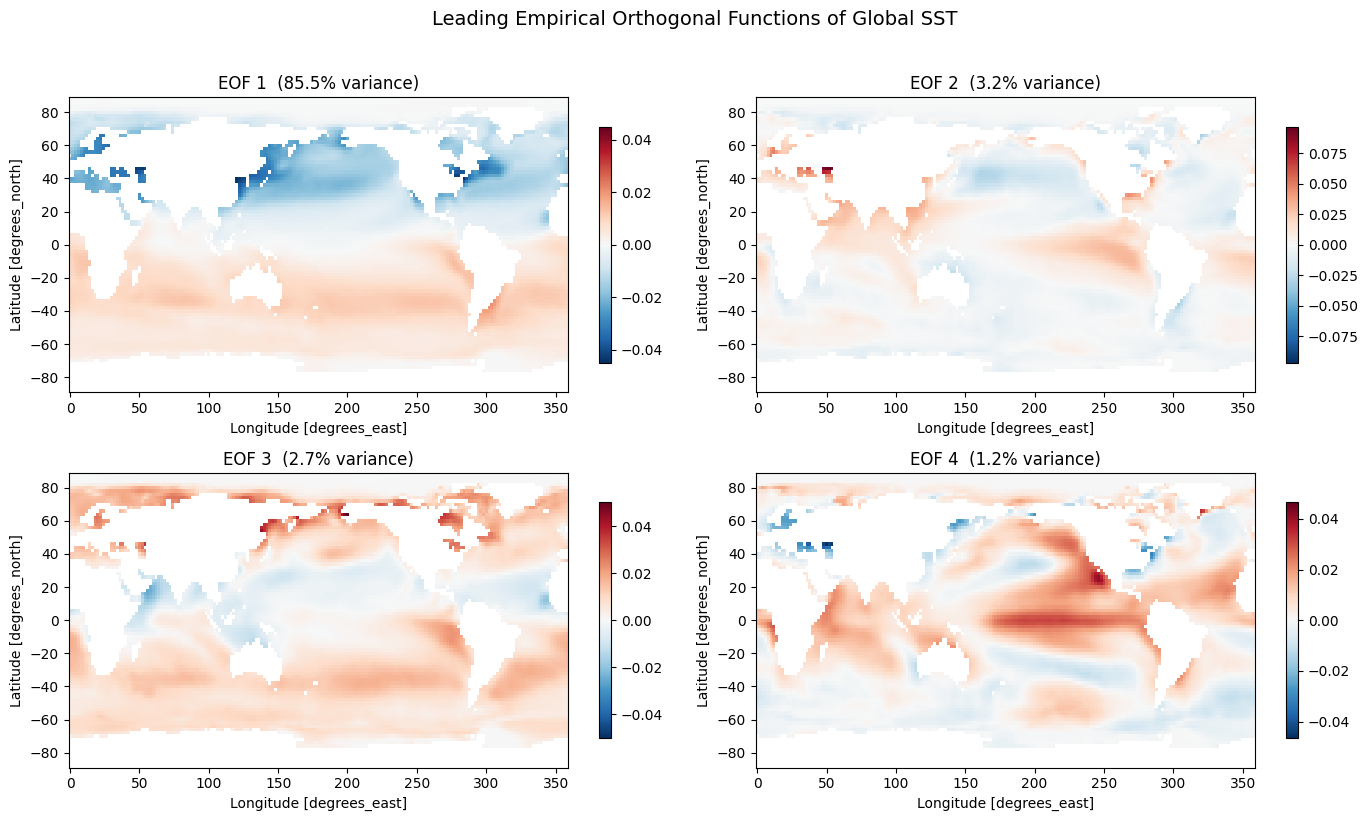

In [30]:
# Plot the leading 4 EOFs
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

for k, ax in enumerate(axes.flat):
    eof_da.sel(mode=k + 1).plot(
        ax=ax, cmap="RdBu_r", center=0,
        cbar_kwargs={"label": "", "shrink": 0.8}
    )
    ax.set_title(f"EOF {k+1}  ({variance_fraction[k]*100:.1f}% variance)")

plt.suptitle("Leading Empirical Orthogonal Functions of Global SST", fontsize=14, y=1.02)
plt.tight_layout()

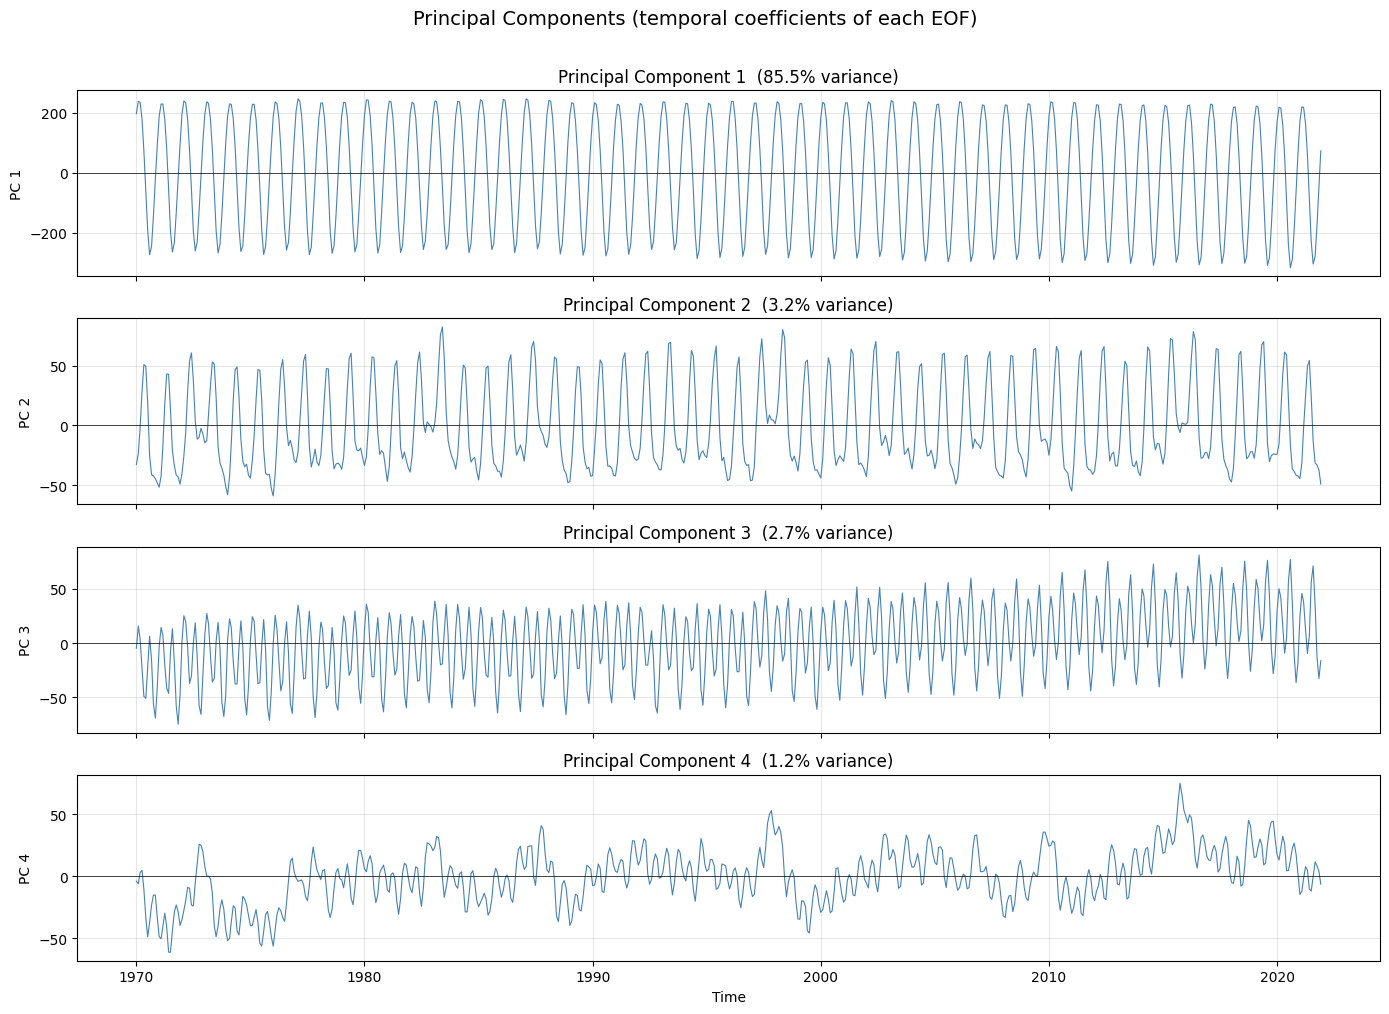

In [31]:
# Plot the corresponding Principal Components (time series)
fig, axes = plt.subplots(4, 1, figsize=(14, 10), sharex=True)

for k, ax in enumerate(axes):
    pc_ts = pc_da.sel(mode=k + 1)
    ax.plot(pc_ts.time, pc_ts.values, linewidth=0.8, color='steelblue')
    ax.axhline(0, color='k', linewidth=0.5)
    ax.set_ylabel(f"PC {k+1}")
    ax.set_title(f"Principal Component {k+1}  ({variance_fraction[k]*100:.1f}% variance)")
    ax.grid(True, alpha=0.3)

axes[-1].set_xlabel("Time")
plt.suptitle("Principal Components (temporal coefficients of each EOF)", fontsize=14, y=1.01)
plt.tight_layout()

### Interpreting the leading modes

What has the SVD found?

- **EOF 1 / PC 1**: This mode should show a strong, slowly-varying trend-like pattern. It captures the dominant mode of SST variability, which is typically related to the global warming trend and/or the overall long-term variability.

- **EOF 2 / PC 2**: This mode often shows the classic **ENSO (El Niño–Southern Oscillation)** pattern — a dipole in the tropical Pacific with a warm tongue extending from the eastern Pacific. The corresponding PC 2 will show clear peaks and troughs corresponding to El Niño and La Niña events.

These patterns are not prescribed — they emerge naturally from the data via the SVD. This is the power of data-driven decomposition.

**Note**: The sign of each EOF/PC pair is arbitrary (we can flip both without changing the data), and the exact ordering may shift depending on the time period chosen. What matters is the spatial pattern and its temporal evolution.

---
## Part 6: Proving the SVD–EOF–PCA Equivalence Numerically

Let's now verify the mathematical relationships from the Rosetta Stone table above by computing EOFs/PCs three different ways and showing they give identical results:

1. **Via SVD** (what we just did)
2. **Via the covariance matrix eigendecomposition** (the textbook EOF method)
3. **Via `sklearn.decomposition.PCA`** (the standard ML approach)

### Method 1: SVD (already done above)

We have:
- `U[:, k]` → EOF $k$
- `s[k] * Vt[k, :]` → PC $k$
- `s[k]**2 / (m - 1)` → eigenvalue $\lambda_k$

In [32]:
m = X.shape[1]  # number of time steps

# EOFs from SVD
eof_svd = U[:, :n_modes]

# PCs from SVD
pc_svd = np.diag(s[:n_modes]) @ Vt[:n_modes, :]

# Eigenvalues from SVD
eigenvalues_svd = s[:n_modes]**2 / (m - 1)

print("Eigenvalues from SVD:")
for k in range(n_modes):
    print(f"  lambda_{k+1} = sigma_{k+1}^2 / (m-1) = {s[k]:.2f}^2 / {m-1} = {eigenvalues_svd[k]:.4f}")

Eigenvalues from SVD:
  lambda_1 = sigma_1^2 / (m-1) = 4560.45^2 / 623 = 33383.0859
  lambda_2 = sigma_2^2 / (m-1) = 887.13^2 / 623 = 1263.2351
  lambda_3 = sigma_3^2 / (m-1) = 815.50^2 / 623 = 1067.4919
  lambda_4 = sigma_4^2 / (m-1) = 543.59^2 / 623 = 474.3024


### Method 2: Covariance matrix eigendecomposition (classical EOF method)

The traditional EOF method forms the spatial covariance matrix:

$$\mathbf{C} = \frac{1}{m-1} \mathbf{X}' {\mathbf{X}'}^T \in \mathbb{R}^{n \times n}$$

and computes its eigendecomposition. However, for large spatial grids, $\mathbf{C}$ can be enormous ($n \times n$). A common trick is to instead work with the smaller **temporal covariance matrix**:

$$\mathbf{R} = \frac{1}{m-1} {\mathbf{X}'}^T \mathbf{X}' \in \mathbb{R}^{m \times m}$$

The eigenvectors of $\mathbf{R}$ are the right singular vectors ($\mathbf{V}$), and the EOFs can be recovered via $\mathbf{U} = \mathbf{X}' \mathbf{V} \boldsymbol{\Sigma}^{-1}$.

In [33]:
# Form the temporal covariance matrix (m x m) — much smaller than (n x n)
R = (X.T @ X) / (m - 1)
print(f"Temporal covariance matrix R shape: {R.shape}")

# Eigendecomposition
eigvals, eigvecs = np.linalg.eigh(R)

# eigh returns ascending order — flip to descending
eigvals = eigvals[::-1]
eigvecs = eigvecs[:, ::-1]

# The eigenvectors of R are the right singular vectors V
# Recover EOFs: U_k = X' @ v_k / sigma_k
eof_eig = np.zeros((X.shape[0], n_modes))
pc_eig = np.zeros((n_modes, m))

for k in range(n_modes):
    sigma_k = np.sqrt(eigvals[k] * (m - 1))  # since sigma_k^2 = lambda_k * (m-1)
    eof_eig[:, k] = X @ eigvecs[:, k] / sigma_k
    pc_eig[k, :] = sigma_k * eigvecs[:, k]

print(f"\nEigenvalues from covariance matrix:")
for k in range(n_modes):
    print(f"  lambda_{k+1} = {eigvals[k]:.4f}")

Temporal covariance matrix R shape: (624, 624)

Eigenvalues from covariance matrix:
  lambda_1 = 33383.0781
  lambda_2 = 1263.2350
  lambda_3 = 1067.4899
  lambda_4 = 474.3028


### Method 3: sklearn PCA

In the ML world, `sklearn.decomposition.PCA` is the go-to tool. Under the hood, it computes the SVD of the mean-centered data — exactly what we've been doing. Let's verify.

Note: sklearn expects data in the shape `(n_samples, n_features)`, i.e. `(time, space)`, which is $\mathbf{X}'^T$ in our convention.

In [34]:
from sklearn.decomposition import PCA

pca = PCA(n_components=n_modes)

# sklearn expects (n_samples, n_features) = (time, space) = X.T
pc_sklearn = pca.fit_transform(X.T)  # shape: (m, n_modes) — these are the PCs

# The "components" in sklearn are the EOFs (but transposed)
eof_sklearn = pca.components_.T  # shape: (n_space, n_modes)

print("sklearn PCA:")
print(f"  Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"  Explained variance (eigenvalues): {pca.explained_variance_}")

sklearn PCA:
  Explained variance ratio: [0.8553 0.0324 0.0273 0.0122]
  Explained variance (eigenvalues): [33383.07    1263.234   1067.492    474.3014]


### Comparing all three methods

Let's verify they produce the same results. Since eigenvectors can differ by a sign, we align signs before comparing.

In [35]:
# Align signs: flip eigenvector methods to match SVD if needed
for k in range(n_modes):
    if np.dot(eof_eig[:, k], eof_svd[:, k]) < 0:
        eof_eig[:, k] *= -1
        pc_eig[k, :] *= -1
    if np.dot(eof_sklearn[:, k], eof_svd[:, k]) < 0:
        eof_sklearn[:, k] *= -1
        pc_sklearn[:, k] *= -1

print("=== Comparison of EOFs ===")
print(f"{'Mode':>6s}  {'SVD vs Eigendecomp':>20s}  {'SVD vs sklearn':>20s}")
for k in range(n_modes):
    err_eig = np.linalg.norm(eof_svd[:, k] - eof_eig[:, k])
    err_skl = np.linalg.norm(eof_svd[:, k] - eof_sklearn[:, k])
    print(f"{k+1:>6d}  {err_eig:>20.2e}  {err_skl:>20.2e}")

print("\n=== Comparison of PCs ===")
print(f"{'Mode':>6s}  {'SVD vs Eigendecomp':>20s}  {'SVD vs sklearn':>20s}")
for k in range(n_modes):
    err_eig = np.linalg.norm(pc_svd[k, :] - pc_eig[k, :])
    err_skl = np.linalg.norm(pc_svd[k, :] - pc_sklearn[:, k])
    print(f"{k+1:>6d}  {err_eig:>20.2e}  {err_skl:>20.2e}")

print("\n=== Comparison of Eigenvalues ===")
print(f"{'Mode':>6s}  {'SVD':>12s}  {'Eigendecomp':>12s}  {'sklearn':>12s}")
for k in range(n_modes):
    print(f"{k+1:>6d}  {eigenvalues_svd[k]:>12.4f}  {eigvals[k]:>12.4f}  {pca.explained_variance_[k]:>12.4f}")

=== Comparison of EOFs ===
  Mode    SVD vs Eigendecomp        SVD vs sklearn
     1              1.11e-07              3.74e-07
     2              6.93e-07              9.21e-07
     3              1.81e-06              4.16e-06
     4              1.77e-06              1.86e-06

=== Comparison of PCs ===
  Mode    SVD vs Eigendecomp        SVD vs sklearn
     1              1.57e-03              8.73e-03
     2              1.93e-03              1.85e-03
     3              5.38e-03              3.05e-03
     4              3.03e-03              1.78e-03

=== Comparison of Eigenvalues ===
  Mode           SVD   Eigendecomp       sklearn
     1    33383.0859    33383.0781    33383.0703
     2     1263.2351     1263.2350     1263.2340
     3     1067.4919     1067.4899     1067.4919
     4      474.3024      474.3028      474.3014


The errors should be at or near machine precision ($\sim 10^{-12}$), confirming that **SVD, EOF analysis, and PCA all produce the same decomposition**. The differences are purely in language and convention, not in mathematics.

---
## Part 7: Reconstruction — How Well Do a Few Modes Capture the Data?

From the theory notebook, we know the truncated SVD gives the optimal low-rank approximation. Let's see what the SST field looks like when reconstructed from just a few modes:

$$
\tilde{\mathbf{X}}_r = \sum_{k=1}^{r} \sigma_k \, \mathbf{u}_k \, \mathbf{v}_k^T = \sum_{k=1}^{r} \text{EOF}_k \cdot \text{PC}_k^T
$$

We'll reconstruct the December 1997 El Niño anomaly field using different numbers of modes.

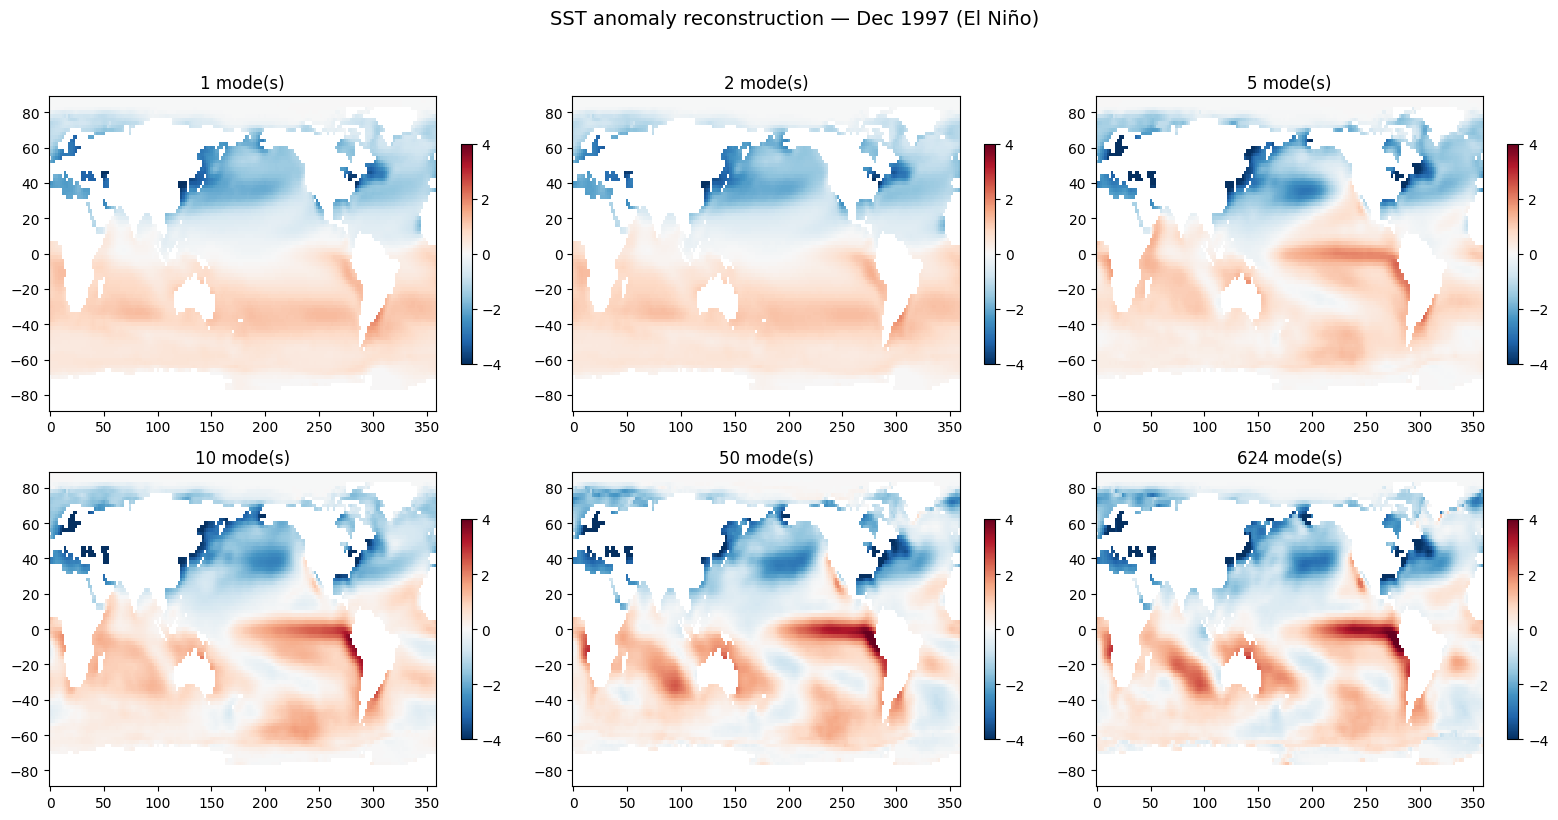

In [36]:
# Find the time index for Dec 1997
dec97_idx = np.argmin(np.abs(time_coord - np.datetime64("1997-12-15")))

fig, axes = plt.subplots(2, 3, figsize=(16, 8))

ranks = [1, 2, 5, 10, 50, X.shape[1]]

for ax, r in zip(axes.flat, ranks):
    # Reconstruct using first r modes
    X_r = U[:, :r] @ np.diag(s[:r]) @ Vt[:r, :]
    
    # Extract Dec 1997 snapshot and map back to (lat, lon)
    snapshot = np.full(n_lat * n_lon, np.nan)
    snapshot[ocean_mask] = X_r[:, dec97_idx]
    snapshot = snapshot.reshape(n_lat, n_lon)
    
    im = ax.pcolormesh(
        sst.lon, sst.lat, snapshot,
        cmap="RdBu_r", vmin=-4, vmax=4, shading="auto"
    )
    ax.set_title(f"{r} mode(s)")
    plt.colorbar(im, ax=ax, shrink=0.7)

plt.suptitle("SST anomaly reconstruction — Dec 1997 (El Niño)", fontsize=14, y=1.02)
plt.tight_layout()

---
## Part 8: Applying the Same Analysis to Surface Air Temperature

To show that this framework is general, let's repeat the analysis on a different variable: **near-surface air temperature** from the NCEP/NCAR Reanalysis. Unlike ERSST, this covers both land and ocean.

In [37]:
ds_air = xr.open_dataset(
    "https://psl.noaa.gov/thredds/dodsC/Datasets/ncep.reanalysis.derived/surface/air.mon.mean.nc"
)
ds_air

<xarray.Dataset> Size: 39MB
Dimensions:  (time: 937, lat: 73, lon: 144)
Coordinates:
  * time     (time) datetime64[ns] 7kB 1948-01-01 1948-02-01 ... 2026-01-01
  * lat      (lat) float32 292B 90.0 87.5 85.0 82.5 ... -82.5 -85.0 -87.5 -90.0
  * lon      (lon) float32 576B 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
Data variables:
    air      (time, lat, lon) float32 39MB ...
Attributes:
    description:                     Data from NCEP initialized reanalysis (4...
    platform:                        Model
    Conventions:                     COARDS
    NCO:                             20121012
    history:                         Thu May  4 20:11:16 2000: ncrcat -d time...
    title:                           monthly mean air.sig995 from the NCEP Re...
    dataset_title:                   NCEP-NCAR Reanalysis 1
    _NCProperties:                   version=2,netcdf=4.6.2,hdf5=1.8.20
    References:                      http://www.psl.noaa.gov/data/gridded/dat...
    DODS_EXTRA.Unlimited_Dimension:  time

In [38]:
# Subset to same period as SST and eagerly load from OPeNDAP
air = ds_air["air"].sel(time=slice("1990-01-01", "2020-12-31")).load()
ds_air.close()

air_mean = air.mean(dim="time")
air_anom = air - air_mean

print(f"Air temperature shape: {air.shape}")
print(f"  (time={air.sizes['time']}, lat={air.sizes['lat']}, lon={air.sizes['lon']})")

Air temperature shape: (372, 73, 144)
  (time=372, lat=73, lon=144)


In [39]:
# Reshape to 2D and apply SVD
air_vals = air_anom.values  # (time, lat, lon)
nt_a, nlat_a, nlon_a = air_vals.shape
X_air = air_vals.reshape(nt_a, nlat_a * nlon_a).T  # (n_space, n_time)

# No NaN mask needed — reanalysis is complete over the grid
X_air = np.nan_to_num(X_air, nan=0.0)

U_air, s_air, Vt_air = np.linalg.svd(X_air, full_matrices=False)
print(f"X_air shape: {X_air.shape}")
print(f"First 6 singular values: {s_air[:6]}")

X_air shape: (10512, 372)
First 6 singular values: [13644.959   3823.0906  1841.1498  1068.3163   971.4913   873.7476]


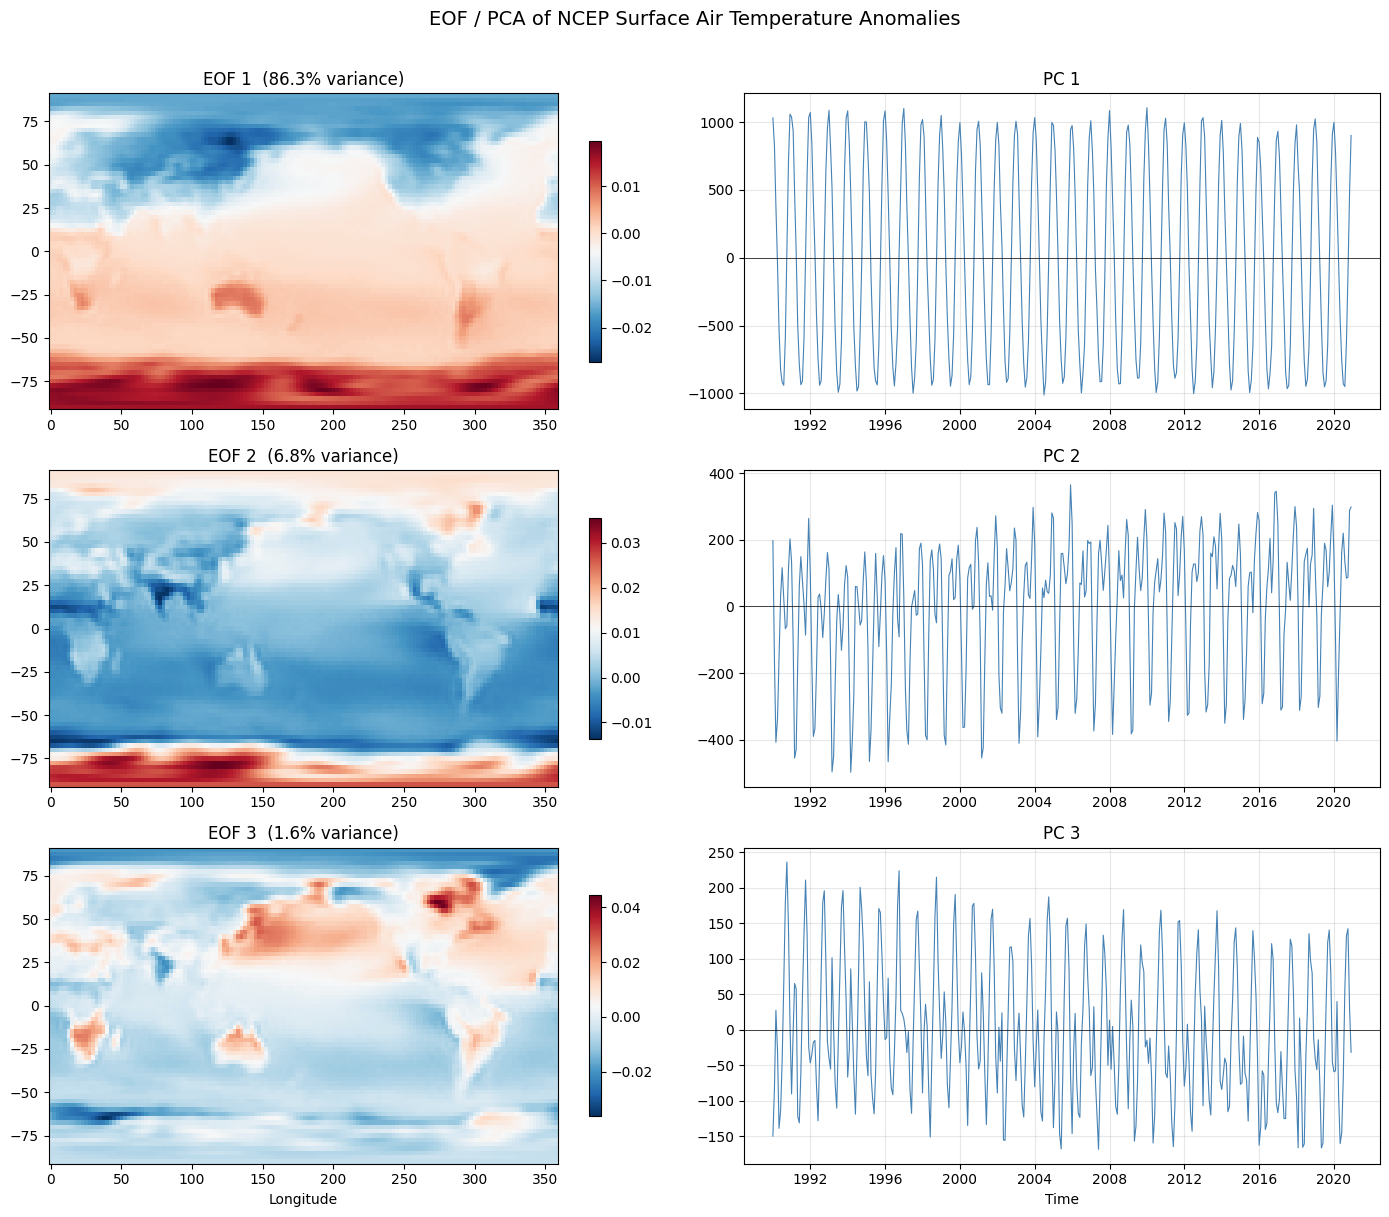

In [40]:
# Variance explained
var_air = s_air**2
varfrac_air = var_air / var_air.sum()

# Visualize leading EOFs and PCs for air temperature
fig, axes = plt.subplots(3, 2, figsize=(14, 12))

for k in range(3):
    # EOF map
    eof_map = U_air[:, k].reshape(nlat_a, nlon_a)
    im = axes[k, 0].pcolormesh(
        air.lon, air.lat, eof_map,
        cmap="RdBu_r", shading="auto"
    )
    axes[k, 0].set_title(f"EOF {k+1}  ({varfrac_air[k]*100:.1f}% variance)")
    plt.colorbar(im, ax=axes[k, 0], shrink=0.7)

    # PC time series
    pc_k = s_air[k] * Vt_air[k, :]
    axes[k, 1].plot(air.time, pc_k, linewidth=0.8, color='steelblue')
    axes[k, 1].axhline(0, color='k', linewidth=0.5)
    axes[k, 1].set_title(f"PC {k+1}")
    axes[k, 1].grid(True, alpha=0.3)

axes[-1, 0].set_xlabel("Longitude")
axes[-1, 1].set_xlabel("Time")
plt.suptitle("EOF / PCA of NCEP Surface Air Temperature Anomalies", fontsize=14, y=1.01)
plt.tight_layout()

---
## Part 9: Beyond PCA — Other Decomposition Techniques

PCA / EOF analysis is the workhorse of climate data analysis, but it has important limitations. Because PCA finds **orthogonal** modes that maximize **variance**, the resulting patterns can mix distinct physical processes into a single mode or split a single process across multiple modes. Several alternative decomposition techniques address these limitations. Here we briefly outline two of the most useful: **Canonical Correlation Analysis (CCA)** and **Independent Component Analysis (ICA)**.

---

### 9.1 Canonical Correlation Analysis (CCA)

**The problem PCA doesn't solve**: PCA analyzes a single field in isolation. But many questions in Earth science involve **relationships between two fields** — for example, how do patterns in sea surface temperature relate to patterns in precipitation? PCA applied separately to each field will find the dominant modes of each, but those modes may not be the ones that are most *coupled* to each other.

**What CCA does**: Given two data matrices $\mathbf{X} \in \mathbb{R}^{n_1 \times m}$ and $\mathbf{Y} \in \mathbb{R}^{n_2 \times m}$ (two fields observed at the same $m$ time steps), CCA finds pairs of linear combinations — one from each field — that are **maximally correlated** with each other.

Specifically, CCA finds vectors $\mathbf{a}_k$ and $\mathbf{b}_k$ such that:

$$
\text{corr}\!\left(\mathbf{a}_k^T \mathbf{X},\; \mathbf{b}_k^T \mathbf{Y}\right) \quad \text{is maximized}
$$

subject to the constraint that successive pairs are uncorrelated with all previous pairs.

**Key properties**:
- The resulting **canonical correlation coefficients** $r_k$ measure how strongly the $k$-th pattern in $\mathbf{X}$ is linearly related to the $k$-th pattern in $\mathbf{Y}$
- Unlike simply correlating PC1 of $\mathbf{X}$ with PC1 of $\mathbf{Y}$, CCA finds the *optimal* pairing — the patterns that are most coupled may not be the ones with the most variance
- CCA is widely used in seasonal forecasting (e.g., relating SST patterns to regional rainfall)

**In practice**, CCA is often preceded by a PCA step on each field to reduce dimensionality and filter noise — this combined approach is sometimes called **CCA on PCA-filtered data** or **Maximum Covariance Analysis (MCA)** in the climate literature. `sklearn.cross_decomposition.CCA` provides a ready-made implementation.

**Earth science applications**:
- Linking tropical Pacific SST patterns to global teleconnection patterns
- Identifying coupled ocean–atmosphere modes
- Statistical downscaling: relating large-scale circulation patterns to local weather variables

---

### 9.2 Independent Component Analysis (ICA)

**The problem PCA doesn't solve**: PCA finds modes that are **orthogonal** and ranked by **variance**. But physical processes are not necessarily orthogonal, and the most important signal may not have the most variance. PCA's orthogonality constraint can produce modes that are mathematical artifacts — linear mixtures of distinct physical processes.

**What ICA does**: ICA finds a linear transformation of the data into components that are as **statistically independent** as possible, not merely uncorrelated. Independence is a much stronger condition than uncorrelatedness — two signals can be uncorrelated but still dependent.

Starting from the data matrix $\mathbf{X}$, ICA finds a mixing matrix $\mathbf{A}$ and independent sources $\mathbf{S}$ such that:

$$
\mathbf{X} = \mathbf{A}\,\mathbf{S}
$$

where the rows of $\mathbf{S}$ are maximally **statistically independent** (typically measured by non-Gaussianity).

**Key properties**:
- ICA components are **not ranked** — there is no natural ordering like PCA's "most variance first"
- ICA components are **not orthogonal** — they can overlap spatially, which is more physically realistic
- ICA requires the sources to be **non-Gaussian** (by the Central Limit Theorem, mixtures tend toward Gaussianity, so maximizing non-Gaussianity recovers the original sources)
- The most common algorithm is **FastICA**, available in `sklearn.decomposition.FastICA`

**Earth science applications**:
- Separating ENSO from the global warming trend (which PCA often mixes into a single mode)
- Identifying distinct regional climate signals that overlap spatially
- Extracting independent source signals in remote sensing (e.g., separating atmospheric constituents in satellite spectra)

---

### 9.3 Quick Comparison

| Property | PCA / EOF | CCA | ICA |
|----------|-----------|-----|-----|
| Input | One field | Two fields | One field |
| Objective | Maximize **variance** | Maximize **cross-correlation** | Maximize **independence** |
| Modes are orthogonal? | Yes | Within each field | No |
| Modes are ranked? | Yes (by variance) | Yes (by correlation) | No |
| Key assumption | None (linear) | Linear relationship | Non-Gaussian sources |
| Typical use case | Dominant variability | Coupled patterns | Source separation |

### 9.4 Other Techniques Worth Knowing

Several other decomposition methods appear frequently in the Earth science literature:

- **Rotated EOF analysis**: Applies a rotation (e.g., varimax) to the leading PCA modes to produce patterns that are more spatially localized and physically interpretable, at the cost of losing the variance-ranking property.

- **Extended EOF (EEOF) analysis**: Augments the data matrix with time-lagged copies of the field, allowing the decomposition to capture propagating features (e.g., eastward-moving waves). Also known as Multichannel Singular Spectrum Analysis (M-SSA).

- **Non-negative Matrix Factorization (NMF)**: Constrains both the spatial patterns and temporal coefficients to be non-negative, which can be useful for fields like precipitation or aerosol concentration where negative values are unphysical. Available in `sklearn.decomposition.NMF`.

- **Dynamic Mode Decomposition (DMD)**: Combines ideas from SVD with linear dynamical systems theory. DMD finds modes that each oscillate at a single frequency, making it natural for identifying periodic phenomena like tides, seasonal cycles, or atmospheric waves.

Each technique makes different assumptions and reveals different aspects of the data. The best choice depends on the scientific question: PCA for dominant variability, CCA for coupled relationships, ICA for separating mixed sources, and the others for specialized goals like propagation or non-negativity.